In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

I will start of with Global Land Temperature by country for data visualization

In [2]:
df_country = pd.read_csv('GlobalLandTemperaturesByCountry.csv')

In [3]:
df_country['year'] = df_country['dt'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").replace(day = 1, month = 1))
df_country.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,year
0,1743-11-01,4.384,2.294,Åland,1743-01-01
1,1743-12-01,NaN,NaN,Åland,1743-01-01
2,1744-01-01,NaN,NaN,Åland,1744-01-01
3,1744-02-01,NaN,NaN,Åland,1744-01-01
4,1744-03-01,NaN,NaN,Åland,1744-01-01


In [4]:
#df_country['dt'] = pd.to_datetime(df_country['dt'])
#df_country['year'] = df_country['dt'].apply(lambda x: x.year)
#df_country['year'] = df_country['year'].apply(lambda x: str(x) + str('-01-01'))
#df_country['year'] = df_country['year'].apply(lambda x: str(x) + str('-01-01'))
#df_country.head()

In [5]:
#because of the large dataset, I will group it by year and see hows the temperature trend
df_country = df_country.dropna(subset = ['AverageTemperature'], axis = 0)
df_country_avgtemp = df_country.groupby(['year'])['AverageTemperature'].mean()
df_country_avgtemp.index = pd.to_datetime(df_country_avgtemp.index)
df_country_avgtemp['2000-01-01']

19.349202134986246

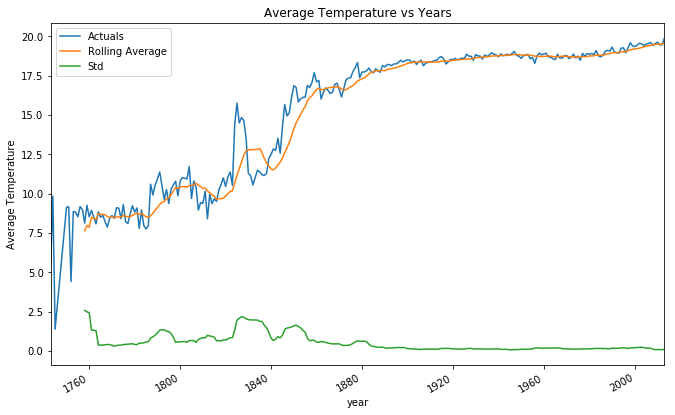

In [6]:
f, ax = plt.subplots(1,1,figsize=(11,7))
df_country_avgtemp.plot(ax = ax,label = 'Actuals')
df_country_avgtemp.rolling(12).mean().plot(ax=ax, label = 'Rolling Average')
df_country_avgtemp.rolling(12).std().plot(ax=ax, label = 'Std')
ax.set_ylabel('Average Temperature')
ax.set_title('Average Temperature vs Years')
ax.legend()

Text(0.5, 1.0, 'Change in Temp per Country')

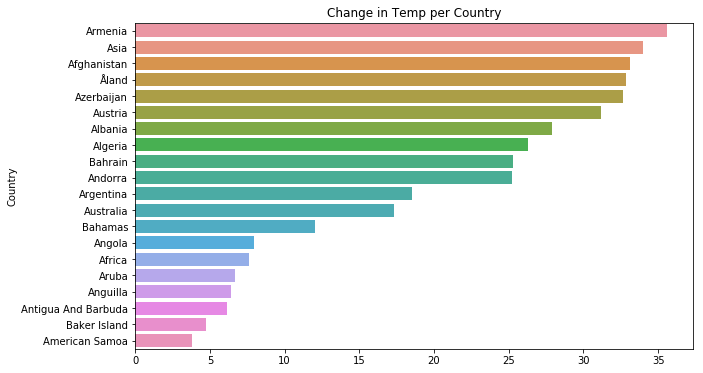

In [7]:
#I want to see whats the difference between max and min temp for each country, only took top 20 to reduce programming time
countries = df_country['Country'].unique()[0:20]
country_difference = []

for i in countries:
    df_country_index = df_country[df_country['Country'] == i][['AverageTemperature']]
    max_temp = df_country_index['AverageTemperature'].max()
    min_temp = df_country_index['AverageTemperature'].min()
    country_difference.append(max_temp - min_temp)
    
#prepare the data, sort, before graphing, option 1
zip_country_diff = zip(countries,country_difference)
country, difference = [list(x) for x in zip(*sorted(zip_country_diff,  key=lambda diff: diff[1], reverse=True))]

#loading the data into a dictionary and then a dataframe, option 2 
#d = {'Country':countries,'Difference':country_difference}
#df = pd.DataFrame(d).sort_values('Difference', ascending = False)

#convertin the zip tuple into a list, and then a dataframe, option 3 
#zip_country_diff = list(zip(countries,country_difference))
#df = pd.DataFrame(zip_country_diff, columns=['country','difference'])

#graphs
f, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(x=difference, y=country)
ax.set_ylabel('Country')
ax.set_title('Change in Temp per Country')


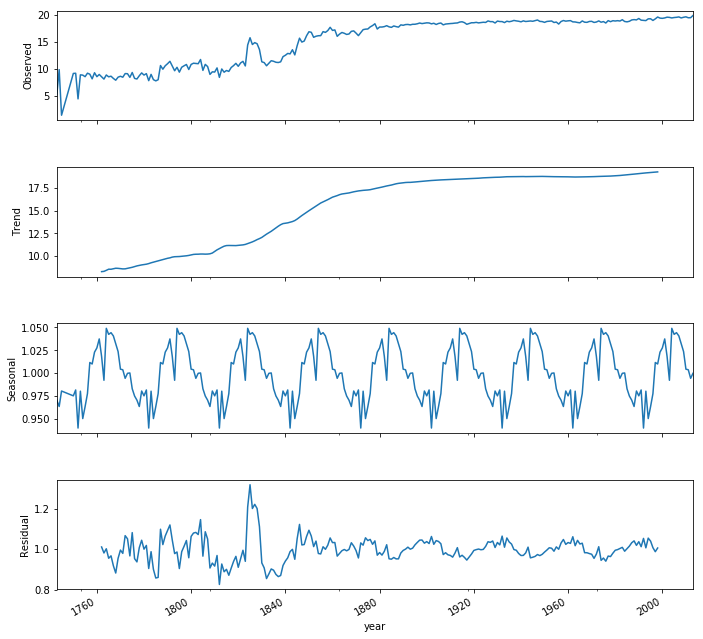

In [8]:
#plot the seasonal decompose
result = seasonal_decompose(df_country_avgtemp, model='multiplicative', freq = 30)

fig = result.plot()
fig.set_size_inches(10.5, 10.5)

In [9]:
#create a model with gridsearch

warnings.filterwarnings("ignore") # specify to ignore warning messages

p = range(0,2)
q = range(0,2)
r = range(0,2)
history = []
aic_score = []
param = list(itertools.product(p,q,r))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in param]

for x in param:
    for y in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(df_country_avgtemp,order=x,seasonal_order=y,
                                          enforce_stationarity=False,enforce_invertibility=False)

            results = model.fit()

            #print('ARIMA{}x{} - AIC:{}'.format(x, y, results.aic))
            history.append([x,y,results.aic])
            aic_score.append(results.aic)
            
        except:
            continue
            
#find the best aic value (which is the lowest), and print the parameters
aic_best = min(aic_score)  
[i for i in history if i[2] ==aic_best]

[[(0, 1, 1), (1, 0, 1, 12), 434.8683900214341]]

In [10]:
model = sm.tsa.statespace.SARIMAX(df_country_avgtemp,order=(0,1,1),seasonal_order=(1,0,1,12),
                                          enforce_stationarity=False,enforce_invertibility=False)
results = model.fit()
print(results.summary())


                                 Statespace Model Results                                 
Dep. Variable:                 AverageTemperature   No. Observations:                  267
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -213.434
Date:                            Thu, 23 May 2019   AIC                            434.868
Time:                                    22:27:45   BIC                            448.986
Sample:                                         0   HQIC                           440.549
                                            - 267                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2171      0.034     -6.432      0.000      -0.283      -0.151
ar.S.L12      -0.1150      0.124   

In [11]:
df_country_avgtemp.head()

year
1743-01-01    5.184140
1744-01-01    9.837898
1745-01-01    1.387125
1750-01-01    9.129353
1751-01-01    9.167388
Name: AverageTemperature, dtype: float64

In [28]:
#create a function and see where's the starting point in the prediction
def start_index(date):
    smaller_df = df_country_avgtemp[:date]
    index = len(smaller_df)-1
    return index

start_index('1840-01-01')

93

In [29]:
pred = results.get_prediction(start=93, dynamic=False)
pred_ci = pred.conf_int()
pred_ci.head()

,lower AverageTemperature,upper AverageTemperature
year,,
1840-01-01,10.948529,13.160918
1841-01-01,11.438066,13.650455
1842-01-01,11.971410,14.183800
1843-01-01,11.739043,13.951433
1844-01-01,12.352540,14.564929


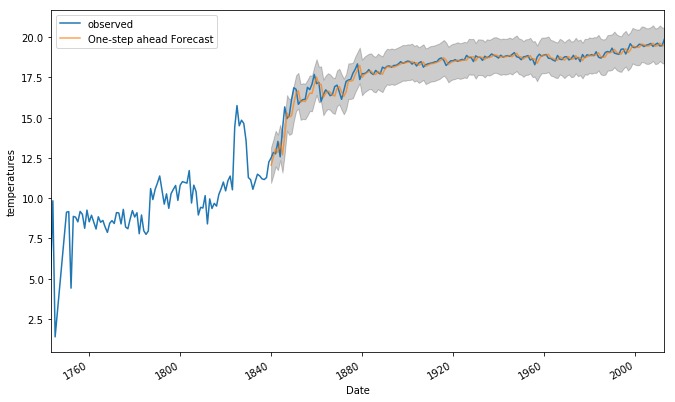

In [30]:
f, ax = plt.subplots(1,1,figsize=(11,7))
ax = df_country_avgtemp.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('temperatures')
plt.legend()

plt.show()